In [1]:
import pickle
import pandas as pd
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Load dataset pkl file
with open('final_data.pkl', 'rb') as f:
    final_df = pickle.load(f)

In [3]:
final_df.salary_estimation.mean()

105923.4592445328

In [4]:
target = final_df.salary_estimation
features = final_df.drop(['salary_estimation'], axis=1)

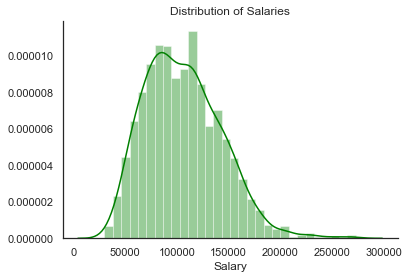

In [5]:
sns.distplot(final_df.salary_estimation, color = 'green')
sns.despine()
plt.title('Distribution of Salaries')
plt.xlabel('Salary')
plt.plot(105923,.00001, label='Data', linestyle='--')

In [6]:
# Keep a holding set for final test
X, X_hold, y, y_hold = train_test_split(features, target, test_size=0.3, random_state=42)

In [7]:
# Split the non holdout data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

### Initial Feature Selection
----

In [8]:
def get_columns(df, prefix):
    column_list = []
    for col in df:
        if prefix in col:
            column_list.append(col)
    return column_list

lang_columns = get_columns(X_train, 'lang_')
skill_columns = get_columns(X_train, 'skill_')
company_columns = get_columns(X_train, 'company_')
degree_columns = get_columns(X_train, 'degree_')
experience_columns = get_columns(X_train, 'experience_')
title_columns = get_columns(X_train, 'title_')
all_columns = get_columns(X_train, '')

column_dict = {'lang_columns': lang_columns, 
               'skill_columns': skill_columns, 
               'company_columns': company_columns,
               'degree_columns': degree_columns,
               'experience_columns': experience_columns,
               'title_columns': title_columns,
               'all_columns': all_columns
              }

In [9]:
def simple_regress_test(model, X, y, columns):
    model.fit(X[columns], y)
    return 'R^2: {0:.3f}'.format(lr.score(X_val[columns], y_val)) 
    

**Simple regression for coding languages**

In [10]:
lr = LinearRegression()
simple_regress_test(lr, X_train, y_train, column_dict['lang_columns'])

'R^2: 0.079'

**Try adding *SKILL* columns**

In [11]:
simple_regress_test(lr, X_train, y_train, column_dict['lang_columns']+column_dict['skill_columns'])

'R^2: 0.154'

**Adding more features helps the model due to having only dummy variables. More features = more information**

**Try also adding *DEGREE* columns**

In [12]:
simple_regress_test(lr, X_train, y_train, column_dict['lang_columns']+
                                          column_dict['skill_columns']+
                                          column_dict['degree_columns']
                   )

'R^2: 0.146'

**Add *EXPERIENCE* features**

In [13]:
simple_regress_test(lr, X_train, y_train, column_dict['lang_columns']+
                                          column_dict['skill_columns']+
                                          column_dict['degree_columns']+
                                          column_dict['experience_columns']
                   )

'R^2: 0.147'

**Experience brought the model lower. Intuition would tell me that experience would directly correlate with salary. Maybe there is a better effect when other features are included. Try adding *TITLE* features instead.**

In [14]:
simple_regress_test(lr, X_train, y_train, column_dict['lang_columns']+
                                          column_dict['skill_columns']+
                                          column_dict['degree_columns']+
                                          column_dict['title_columns']
                   )

'R^2: 0.282'

**Now try adding *COMPANY* details to the model**

In [15]:
simple_regress_test(lr, X_train, y_train, column_dict['lang_columns'] +
                                          column_dict['skill_columns'] +
                                          column_dict['degree_columns'] +
                                          column_dict['title_columns'] +
                                          column_dict['company_columns']
                   )

'R^2: 0.277'

**Company details and experience are not helping this model predict price. The FINAL FEATURES will be:**

- **Programming Language**
- **Skills related to Data**
- **Degree**
- **Title**

In [16]:
final_columns = lang_columns + skill_columns + degree_columns + title_columns

simple_regress_test(lr, X_train, y_train, final_columns)
test_prediction = lr.predict(X_val[final_columns])

lr.score(X_val[final_columns], y_val)

0.28185823697266144

In [17]:
print('R^2 training: {0:.3f}'.format(lr.score(X_train[final_columns], y_train)))

R^2 training: 0.311


In [18]:
print('R^2 validation: {0:.3f}'.format(lr.score(X_val[final_columns], y_val)))

R^2 validation: 0.282


**The final feature scores are not too far off from each other. Try visualizing to see the relationship.**

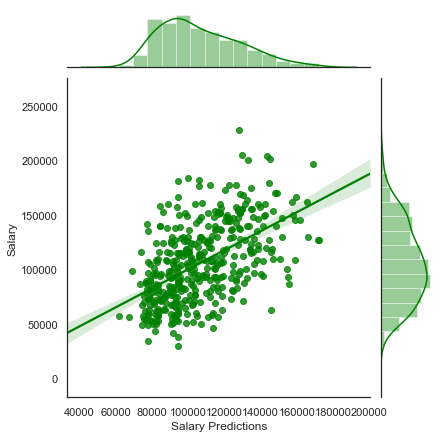

In [19]:
sns.jointplot(test_prediction,y_val, kind='regplot', color = 'green')
plt.ylabel('Salary')
plt.xlabel('Salary Predictions')

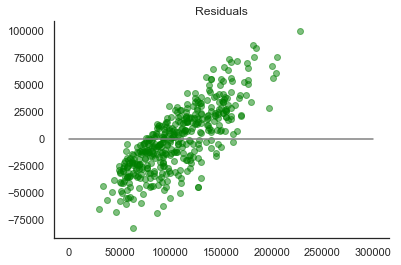

In [20]:
plt.scatter(y_val, y_val-test_prediction,alpha=.5, color='green')
plt.plot(np.linspace(0,300000,1000),np.linspace(0,0,1000), color = 'grey')
plt.title('Residuals')
sns.despine()


**Root Mean Square Error**

In [21]:
np.sqrt(np.mean((test_prediction - y_val)**2))

30196.430628946662

**Regularizaton may help a bit since there are many features, but first attempt to relate different features together. Try different methods of transformation and polynomials to reduce the linear trend of the residuals**

### Feature Transforms
---

**Check what the coefficients are for the chosen features**

In [56]:
def get_linear_coefficients(column_dict, X_train, y_train, linear_model):
    linear_dict = {}
    for key, column in column_dict.items():
        linear_model.fit(X_train.loc[:, column], y_train)
        #sns.set()
        #sns.barplot(column, linear_model.coef_)
        linear_dict[key] = list(zip(column, linear_model.coef_))
    return linear_dict

In [57]:
column_dict = {'lang_columns': lang_columns, 
               'skill_columns': skill_columns, 
               'degree_columns': degree_columns,
               'title_columns': title_columns,
              }
coefficient_dict = get_linear_coefficients(column_dict, X_train, y_train, lr)
pprint.pprint(coefficient_dict)

{'degree_columns': [('degree_ms', 5484.7875597599696),
                    ('degree_bs', -15218.13901517273),
                    ('degree_phd', 16528.38400576913)],
 'lang_columns': [('lang_java', 9278.9356364383748),
                  ('lang_sql', -5979.1974090562353),
                  ('lang_python', 22477.580099761119),
                  ('lang_javascript', -3411.2931959196717),
                  ('lang_r', 414.08802734615841)],
 'skill_columns': [('skill_visualization', -2673.6056498092516),
                   ('skill_machinelearning', 13152.506577612327),
                   ('skill_bigdata', 17742.474813750938),
                   ('skill_communication', -3194.4321402382943),
                   ('skill_datamining', -1973.5734390331693),
                   ('skill_aws', 14535.743366038716),
                   ('skill_stats', -1572.628377015898),
                   ('skill_predictive', 6339.4301381460882),
                   ('skill_algorithm', 4935.5296382832703),
               

In [61]:
degree_coef = coefficient_dict['degree_columns']

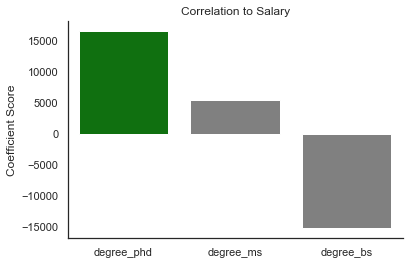

In [78]:
degree_coef.sort(key=lambda x: x[1], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
coefficient = zip(*degree_coef)[0]
score = zip(*degree_coef)[1]
x_pos = np.arange(len(coefficient)) 

# calculate slope and intercept for the linear trend line
#slope, intercept = np.polyfit(x_pos, score, 1)
#trendline = intercept + (slope * x_pos)


clrs = ['grey' if (x < max(score)) else 'green' for x in score ]
sns.barplot(x_pos, score, palette=clrs)#,align='center')
sns.despine()
plt.title('Correlation to Salary')
plt.xticks(x_pos, coefficient) 
plt.ylabel('Coefficient Score')
plt.show()

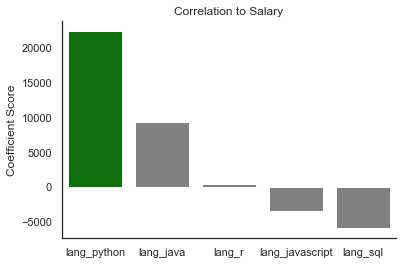

In [80]:
lang_coef = coefficient_dict['lang_columns']
lang_coef.sort(key=lambda x: x[1], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
coefficient = zip(*lang_coef)[0]
score = zip(*lang_coef)[1]
x_pos = np.arange(len(coefficient)) 

# calculate slope and intercept for the linear trend line
#slope, intercept = np.polyfit(x_pos, score, 1)
#trendline = intercept + (slope * x_pos)


clrs = ['grey' if (x < max(score)) else 'green' for x in score ]
sns.barplot(x_pos, score, palette=clrs)#,align='center')
sns.despine()
plt.title('Correlation to Salary')
plt.xticks(x_pos, coefficient) 
plt.ylabel('Coefficient Score')
plt.show()

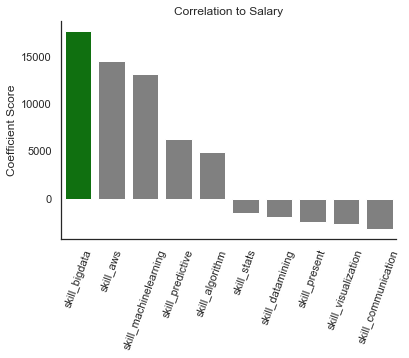

In [82]:
skill_coef = coefficient_dict['skill_columns']
skill_coef.sort(key=lambda x: x[1], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
coefficient = zip(*skill_coef)[0]
score = zip(*skill_coef)[1]
x_pos = np.arange(len(coefficient)) 

# calculate slope and intercept for the linear trend line
#slope, intercept = np.polyfit(x_pos, score, 1)
#trendline = intercept + (slope * x_pos)

plt.xticks(rotation=70)
clrs = ['grey' if (x < max(score)) else 'green' for x in score ]
sns.barplot(x_pos, score, palette=clrs)#,align='center')
sns.despine()
plt.title('Correlation to Salary')
plt.xticks(x_pos, coefficient) 
plt.ylabel('Coefficient Score')
plt.show()

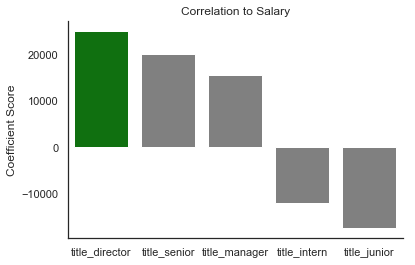

In [83]:
title_coef = coefficient_dict['title_columns']
title_coef.sort(key=lambda x: x[1], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
coefficient = zip(*title_coef)[0]
score = zip(*title_coef)[1]
x_pos = np.arange(len(coefficient)) 

# calculate slope and intercept for the linear trend line
#slope, intercept = np.polyfit(x_pos, score, 1)
#trendline = intercept + (slope * x_pos)


clrs = ['grey' if (x < max(score)) else 'green' for x in score ]
sns.barplot(x_pos, score, palette=clrs)#,align='center')
sns.despine()
plt.title('Correlation to Salary')
plt.xticks(x_pos, coefficient) 
plt.ylabel('Coefficient Score')
plt.show()

**Boxplots of important coefficients**

In [24]:
#sns.boxplot(coefficient_dict['lang_columns'], y_train)
coefficient_dict['lang_columns']

[('lang_java', 9278.9356364383748),
 ('lang_sql', -5979.1974090562353),
 ('lang_python', 22477.580099761119),
 ('lang_javascript', -3411.2931959196717),
 ('lang_r', 414.08802734615841)]

In [25]:
poly = PolynomialFeatures(degree=2) 

In [26]:
lr_poly = LinearRegression()
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

lr_poly.fit(X_train_poly, y_train)
lr_poly.score(X_val_poly, y_val)

-1.8859867266183864e+18

**Polynomial features do not bode well with this model. This is possibly due to the categorical nature of the features. Try relating features in the same categories with one another.**

**Relate features related to LANGUAGE**

In [27]:
lang_relation_df = final_df[get_columns(final_df, 'lang_')]
relation_df1 = final_df.copy()
for i, col in enumerate(lang_relation_df.columns[:-1]):
    for j, col2 in enumerate(lang_relation_df.columns[i+1:]):
        relation_df1[col+'*'+col2] = relation_df1[col] * relation_df1[col2]

In [28]:
target = relation_df1.salary_estimation
features = relation_df1.drop(['salary_estimation'], axis=1)
X1, X1_hold, y1, y1_hold = train_test_split(features, target, test_size=0.3, random_state=42)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [29]:
lr = LinearRegression()
simple_regress_test(lr, X1_train, y1_train, final_columns)
print('R^2 validation: {0:.9f}'.format(lr.score(X1_val[final_columns], y1_val)))

R^2 validation: 0.281858237


**Programming language relations had no effect on the model. Try again with SKILL features**

In [30]:
skill_relation_df = final_df[get_columns(final_df, 'skill_')]
relation_df2 = final_df.copy()
for i, col in enumerate(skill_relation_df.columns[:-1]):
    for j, col2 in enumerate(skill_relation_df.columns[i+1:]):
        relation_df2[col+'*'+col2] = relation_df2[col] * relation_df2[col2]

In [31]:
target = relation_df2.salary_estimation
features = relation_df2.drop(['salary_estimation'], axis=1)
X2, X2_hold, y2, y2_hold = train_test_split(features, target, test_size=0.3, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [32]:
lr = LinearRegression()
simple_regress_test(lr, X2_train, y2_train, final_columns)
print('R^2 validation: {0:.9f}'.format(lr.score(X2_val[final_columns], y2_val)))

R^2 validation: 0.281858237


**Skill relations also had no effect on the model.**

**Try one more time relating both SKILLS and LANGUAGES**

In [33]:
s_l_relation_df = pd.concat([final_df[lang_columns], final_df[skill_columns]], axis=1, sort=False)
relation_df3 = final_df.copy()
for i, col in enumerate(s_l_relation_df.columns[:-1]):
    for j, col2 in enumerate(s_l_relation_df.columns[i+1:]):
        relation_df3[col+'*'+col2] = relation_df3[col] * relation_df2[col2]

In [34]:
target = relation_df3.salary_estimation
features = relation_df3.drop(['salary_estimation'], axis=1)
X3, X3_hold, y3, y3_hold = train_test_split(features, target, test_size=0.3, random_state=42)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [35]:
lr = LinearRegression()
simple_regress_test(lr, X3_train, y3_train, final_columns)
print('R^2 validation: {0:.9f}'.format(lr.score(X3_val[final_columns], y3_val)))

R^2 validation: 0.281858237


**Multiplying the columns that would intuitively be related had NO EFFECT on the model. **

**Try using regularization to constrain the large amount of features**

### Regularization
---

In [36]:
alphas = [.001, .01, .1, 1, 10, 100]

kf = KFold(n_splits=5, random_state=42)

In [37]:
std = StandardScaler()
std.fit(X_train[final_columns])
X_tr = std.transform(X_train[final_columns])
X_te = std.transform(X_val[final_columns])

In [38]:
alphavec = 10**np.linspace(-3,9,27)

lr_model = LassoCV(alphas = alphavec, cv=5)
lr_model.fit(X_tr,y_train)

LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [39]:
lr_model.alpha_

345.51072945922181

In [40]:
list(zip(X_train[final_columns].columns,lr_model.coef_))

[('lang_java', 1384.5089969763421),
 ('lang_sql', -1592.6445836221681),
 ('lang_python', 5125.3671738502053),
 ('lang_javascript', 820.50410182861003),
 ('lang_r', -0.0),
 ('skill_visualization', -561.37388885028611),
 ('skill_machinelearning', 4101.7406628607705),
 ('skill_bigdata', 5517.9137121385511),
 ('skill_communication', -1692.7511519009606),
 ('skill_datamining', -121.99437902503065),
 ('skill_aws', 3570.9151457935809),
 ('skill_stats', -0.0),
 ('skill_predictive', 85.538861772518203),
 ('skill_algorithm', 1127.1909745113826),
 ('skill_present', -449.88796195569904),
 ('degree_ms', 339.31256788379181),
 ('degree_bs', -5527.7980258148746),
 ('degree_phd', 1714.8934707031015),
 ('title_director', 5729.5915061644037),
 ('title_intern', -1893.0159837730391),
 ('title_manager', 6004.5850966030148),
 ('title_senior', 7867.2043187491527),
 ('title_junior', -507.27467660634085)]

In [42]:
test_set_pred = lr_model.predict(X_val[final_columns])

**RMSE went up when using Lasso regression.**

In [43]:
np.sqrt(np.mean((test_set_pred - y_val)**2))

32477.138278821429

### Final Model
---

**The best model for this data is the original linear model with no fetures added. **

In [44]:
simple_regress_test(lr, X_train, y_train, final_columns)
test_prediction = lr.predict(X_hold[final_columns])

lr.score(X_hold[final_columns], y_hold)

0.31433277233975099

In [45]:
np.sqrt(np.mean((test_prediction - y_hold)**2))

31892.87760911338

In [ ]:
'''
for a in alphas:
    cv_lm_r2s, cv_lasso_r2s, cv_ridge_r2s  = [], [], []
    
    for train_index, val_index in kf.split(X,y):
        print(train_index)
        print(val_index)
        
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]
        
        # simple linear regression
        lm = LinearRegression
        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
        
        # Need to standardize for regularization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
    
        # Lasso regression with scaling
        lm_lass = Lasso(a)
        lm_lass.fit(X_train, y_train)
        cv_lasso_r2s.append(lm_lass.score(X_val, y_val))
        
        # Ridge regression with scaling
        lm_ridge = Ridge(a)
        lm_ridge.fit(X_train, y_train)
        cv_ridge_r2s.append(lm_ridge.score(X_val, y_val))
        
print('Simple regression r2s: ', cv_lm_r2s)
print('Lasso r2s: ', cv_lasso_r2s)
print('Ridge r2s: ', cv_ridge_r2s, '\n')

print('Simple mean cv r^2:{0:.3f}'.format(np.mean(cv_lm_r2s)))
print('Lasso mean cv r^2: {0:.3f}'.format(np.mean(cv_lasso_r2s)))  
print('Ridge mean cv r^2: {0:.3f}'.format(np.mean(cv_ridge_r2s)))    
'''